# Human sounds Classifier (Cat, Dog, Bird)
From the publibly available dataset (https://www.kaggle.com/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification)

In [59]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display

In [60]:
dataset_path = './Dataset/Animals'
data_dir = pathlib.Path(dataset_path)

print(data_dir)

Dataset\Animals


In [61]:
words = np.array(os.listdir(data_dir))
print("Dataset Words: ", words)

Dataset Words:  ['bird' 'cat' 'dog']


In [62]:
train, val = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size = 64,
    validation_split = 0.2,
    seed=0,
    output_sequence_length = 16000,
    subset='both'
)

labels = np.array(train.class_names)
print("Labels ", labels)

Found 610 files belonging to 3 classes.
Using 488 files for training.
Using 122 files for validation.
Labels  ['bird' 'cat' 'dog']


In [63]:
train.element_spec

for a, l in train.take(1):
    print(a.shape)

(64, 16000, 1)


In [64]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train = train.map(squeeze, tf.data.AUTOTUNE)
val = val.map(squeeze, tf.data.AUTOTUNE)

In [65]:
for a, l in train.take(1):
    print(a.shape)

(64, 16000)


In [66]:
test = val.shard(num_shards=2, index=0)
val = val.shard(num_shards=2, index=1)

In [67]:
for example_audio, example_labels in train.take(1):
    print(example_audio.shape)
    print(example_labels.shape)


(64, 16000)
(64,)


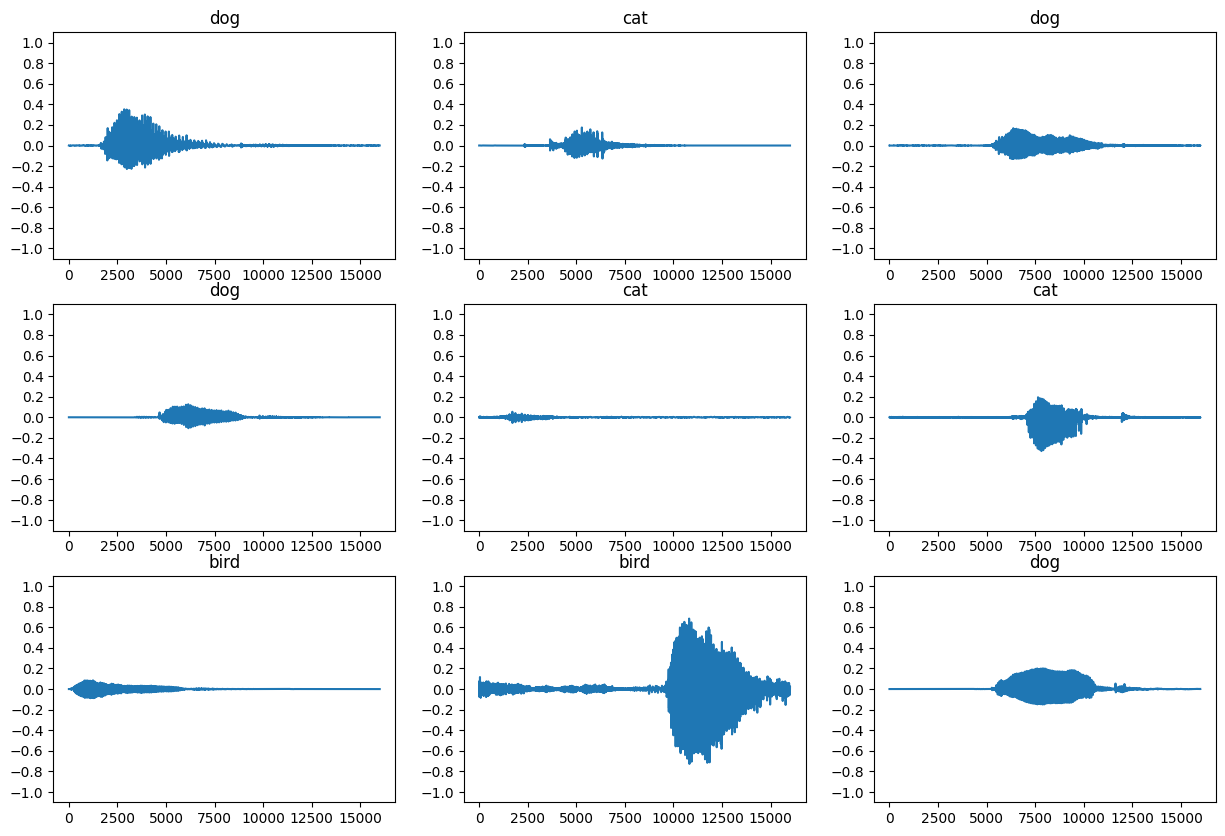

In [68]:
plt.figure(figsize=(15,10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(labels[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [69]:
def get_spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [70]:
for i in range(3):
    label = labels[example_labels[i]]
    waveform = example_audio[i]
    spectogram = get_spectogram(waveform)

    print("Label: ", label)
    print("Waverform shape: ", waveform.shape)
    print("Spectogram shape: ", spectogram.shape)
    print("Audio Playback")

    display.display(display.Audio(waveform, rate=16000))

Label:  dog
Waverform shape:  (16000,)
Spectogram shape:  (124, 129, 1)
Audio Playback


Label:  cat
Waverform shape:  (16000,)
Spectogram shape:  (124, 129, 1)
Audio Playback


Label:  dog
Waverform shape:  (16000,)
Spectogram shape:  (124, 129, 1)
Audio Playback


In [71]:
print(train.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [72]:
def plot_spectogram(spectogram, ax):
    if len(spectogram.shape) > 2:
        assert len(spectogram.shape) == 3
        spectogram = np.squeeze(spectogram, axis=-1)
    
    log_spec = np.log(spectogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

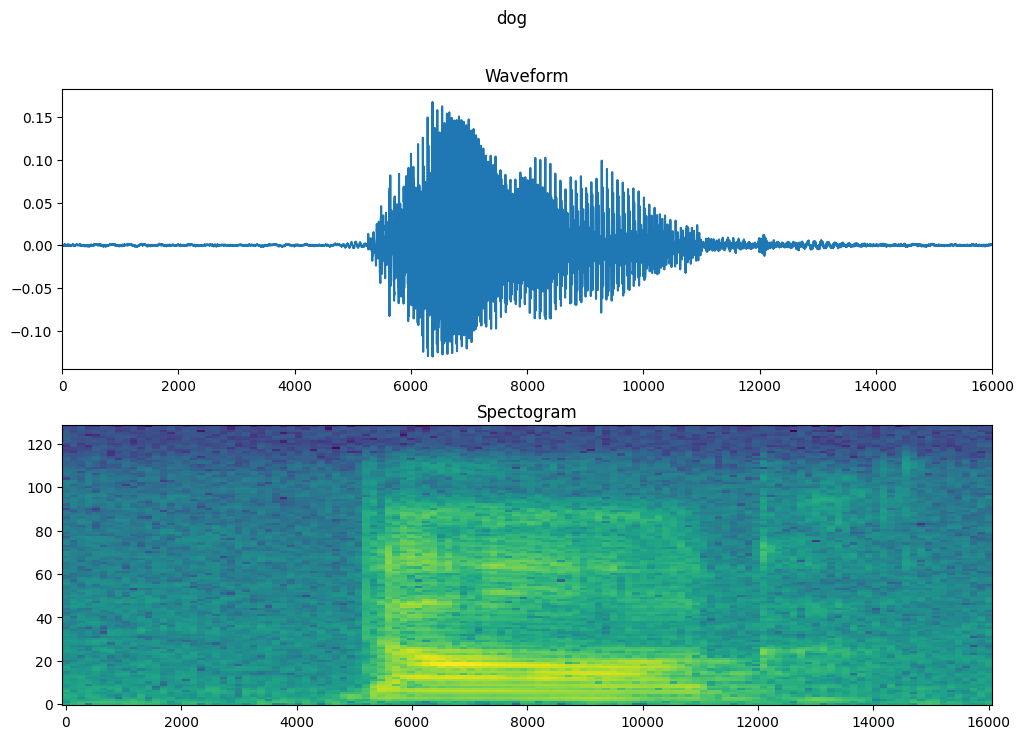

In [73]:
fig, ax = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
ax[0].plot(timescale, waveform.numpy())
ax[0].set_title("Waveform")
ax[0].set_xlim([0,16000])

plot_spectogram(spectogram.numpy(), ax[1])
ax[1].set_title("Spectogram")
plt.suptitle(label)
plt.show()

In [74]:
def make_spec_ds(ds):
    return ds.map(map_func=lambda audio, label: (get_spectogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectogram = make_spec_ds(train)
val_spectogram = make_spec_ds(val)
test_spectogram = make_spec_ds(test)

In [75]:
for example_spectograms, example_spectograms_labels in train_spectogram.take(1):
    break

print(example_spectograms.shape)

(64, 124, 129, 1)


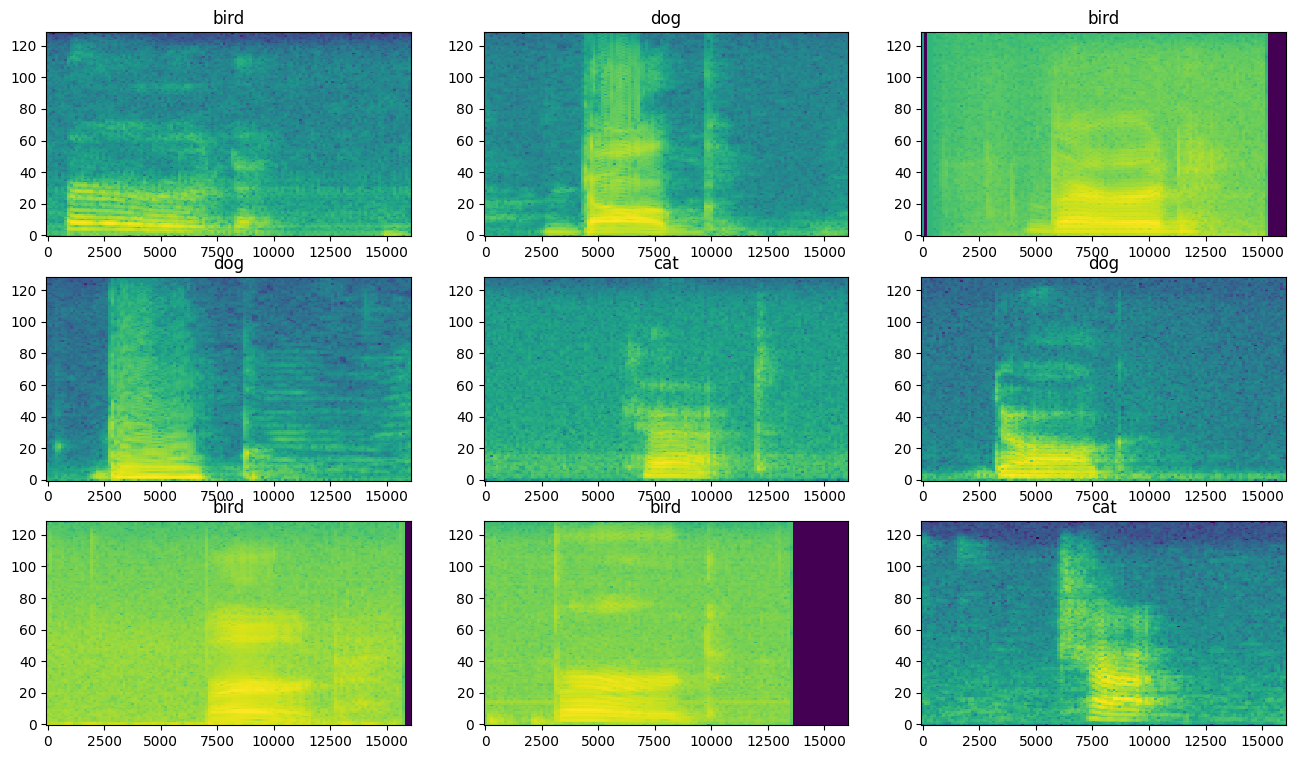

In [76]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16,9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectogram(example_spectograms[i].numpy(), ax)
    ax.set_title(labels[example_spectograms_labels[i].numpy()])

plt.show()


In [77]:
train_spectogram = train_spectogram.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectogram = val_spectogram.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram = test_spectogram.cache().prefetch(tf.data.AUTOTUNE)

In [78]:
input_shape = example_spectograms.shape[1:]
print("Input shape: ", input_shape)
num_labels = len(labels)

normalizer = layers.Normalization()
normalizer.adapt(data=train_spectogram.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    normalizer,
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.125),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

Input shape:  (124, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,582 (221.03 KB)

 Trainable params: 56,579 (221.01 KB)

 Non-trainable params: 3 (16.00 B)

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [80]:
EPOCHS = 10
history = model.fit(
    train_spectogram,
    validation_data = val_spectogram,
    epochs = EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.3487 - loss: 1.1381 - val_accuracy: 0.4483 - val_loss: 1.0696
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4401 - loss: 1.0308 - val_accuracy: 0.5517 - val_loss: 1.0494
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5268 - loss: 0.9767 - val_accuracy: 0.6724 - val_loss: 1.0255
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5904 - loss: 0.9161 - val_accuracy: 0.6897 - val_loss: 0.9961
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6304 - loss: 0.8353 - val_accuracy: 0.7241 - val_loss: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6854 - loss: 0.8242 - val_accuracy: 0.7759 - val_loss: 0.8992
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6919 - loss: 0.7235 - val_accuracy: 0.7759 - val_loss: 0.8148
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7456 - loss: 0.7314 - val_accuracy: 0.7931 - val_loss: 0.7663
E

Text(0, 0.5, 'Accuracy [%]')

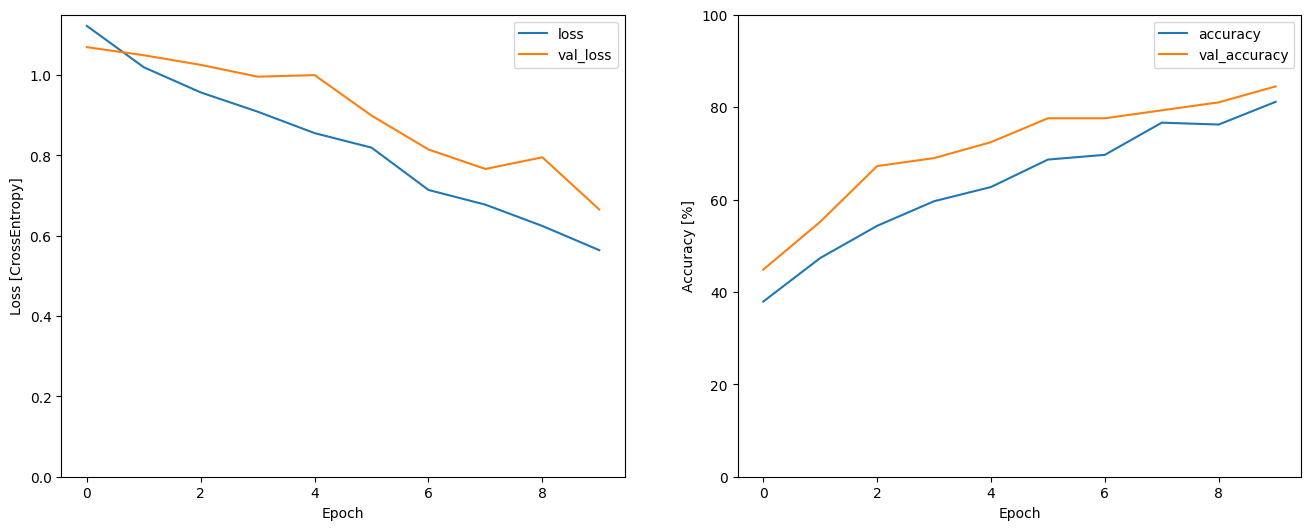

In [81]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics["accuracy"]), 100*np.array(metrics["val_accuracy"]))
plt.legend(["accuracy", "val_accuracy"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [82]:
model.evaluate(test_spectogram, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7969 - loss: 0.5416


{'accuracy': 0.796875, 'loss': 0.5416467189788818}

In [83]:
y_pred = model.predict(test_spectogram)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [84]:
y_pred = tf.argmax(y_pred, axis=1)

In [85]:
y_true = tf.concat(list(test_spectogram.map(lambda spec, lab: lab)), axis=0)

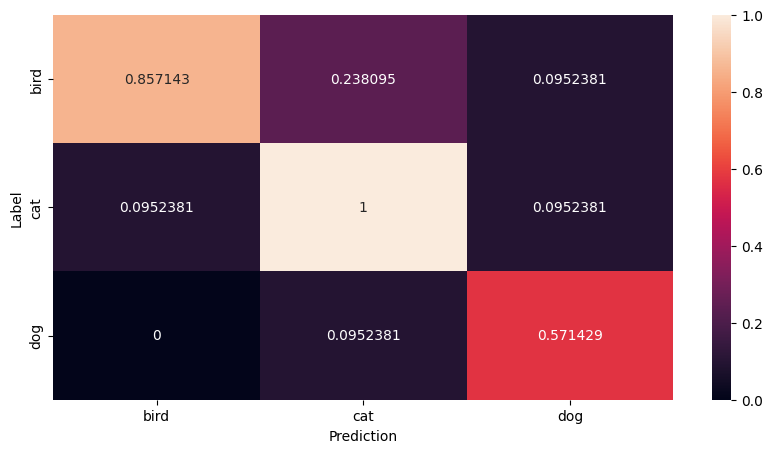

In [86]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
confusion_mtx = confusion_mtx / np.max(confusion_mtx)
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()